In [1]:
print('')

aim to plot change in gradient as consider changing minimum magntiude of data

In [4]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pickle
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import math

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [145]:
filenames = ['eq_object_03s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_05s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_1s_bandpass_01_19_snr_20_blank_0_new',
            'eq_object_4s_bandpass_01_19_snr_20_blank_0_new']

'''filenames = ['eq_object_03s_bandpass_01_19_snr_20_blank_0_new',
              'eq_object_03s_bandpass_01_19_snr_20_blank_005_new',
              'eq_object_03s_bandpass_01_19_snr_20_blank_01_new']

filenames = ['eq_object_05s_bandpass_01_19_snr_20_blank_0_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_005_new', 
             'eq_object_05s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_05s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_0_new', 
             'eq_object_1s_bandpass_01_19_snr_20_blank_005_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_01_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_025_new',
             'eq_object_1s_bandpass_01_19_snr_20_blank_05_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_0_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_005_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_01_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_025_new',
              'eq_object_4s_bandpass_01_19_snr_20_blank_05_new']'''

magnitudes = np.arange(3,8, 0.1)

In [424]:
def sort_tp_data(df, mag_lim = 0):
    list_tp_all = list(df.tp_max)
    list_mag_all = list(df.eq_mag)
    list_mag = []
    list_tpmax = []
    count = 0
    for m in range(0, len(list_mag_all)):
        if list_mag_all[m] > mag_lim:
            list_mag.append(list_mag_all[m])
            list_tpmax.append([])
            for d in range(0, len(list_tp_all[m])):
                if list_tp_all[m][d] != None and list_tp_all[m][d]>0:
                    list_tpmax[count].append(list_tp_all[m][d])
            count += 1
    return list_mag, list_tpmax

def sort_tc_data(df, mag_lim = 0):
    list_tc_all = list(df.tc)
    list_mag_all = list(df.eq_mag)
    list_mag = []
    list_tc = []
    count = 0
    for m in range(0, len(list_mag_all)):
        if list_mag_all[m] > mag_lim:
            list_mag.append(list_mag_all[m])
            list_tc.append([])
            for d in range(0, len(list_tc_all[m])):
                if list_tc_all[m][d] != None and list_tc_all[m][d]>0:
                    list_tc[count].append(list_tc_all[m][d])
            count += 1
    return list_mag, list_tc

def sort_iv2_data(df, mag_lim = 0):
    list_iv2_all = list(df.iv2)
    list_mag_all = list(df.eq_mag)
    list_dist_Distance = list(df.iv2_distances)
    list_dist = []
    list_mag = []
    list_iv2 = []
    eq = 0
    for m in range(0, len(list_mag_all)):
        if list_mag_all[m]>mag_lim:
            someTrue = len(list_iv2_all[m])
            for d in range(0, len(list_dist_Distance[m])):
                if list_iv2_all[m][d] != None:
                    list_mag.append(list_mag_all[m])
                    list_iv2.append(list_iv2_all[m][d])
                    list_dist.append(float(str(np.array(list_dist_Distance[m][d]))[:-3]))
    return list_mag, list_iv2, list_dist
def sort_pgd_data(df, mag_lim = 0):
    list_pgd_all = list(df.pgd)
    list_mag_all = list(df.eq_mag)
    list_dist_Distance = list(df.pgd_distances)
    list_dist = []
    list_mag = []
    list_pgd = []
    eq = 0
    for m in range(0, len(list_mag_all)):
        if list_mag_all[m]>mag_lim:
            someTrue = len(list_pgd_all[m])
            for d in range(0, len(list_dist_Distance[m])):
                if list_pgd_all[m][d] != None:
                    list_mag.append(list_mag_all[m])
                    list_pgd.append(list_pgd_all[m][d])
                    list_dist.append(float(str(np.array(list_dist_Distance[m][d]))[:-3]))
                else:
                    someTrue -= 1
            if someTrue >0:
                eq += 1
    return list_mag, list_pgd, list_dist

In [459]:
def calc_tp_mag_lim(df, mag_lim):
    #print(mag_lim)
    list_mags, list_tpmax = sort_tp_data(df, mag_lim)
    params = []
    y_aves_tp = []
    x_aves_tp = []
    i = 0
    for i  in range(0, len(list_mags)):
        if len(list_tpmax[i])>=1:
            mean_tp = np.mean(list_tpmax[i]) 
            std_tp = np.std(list_tpmax[i]) 
            y_tp = [] 
            for j in list_tpmax[i]: 
                if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                    y_tp.append(math.log(j, 10))
                elif len(list_tpmax[i])==1:
                    y_tp.append(math.log(j, 10))
            x_tp = np.zeros(len(y_tp))  
            x_tp = x_tp + list_mags[i]
            c = 0
            if math.isnan(np.median(y_tp))==False:  
                y_aves_tp.append(np.median(y_tp))
                x_aves_tp.append(list_mags[i])
    return x_aves_tp, y_aves_tp

def calc_tc_mag_lim(df, mag_lim):
    #print(mag_lim)
    list_mags, list_tc = sort_tc_data(df, mag_lim)
    params = []
    y_aves_tc = []
    x_aves_tc = []
    i = 0
    for i  in range(0, len(list_mags)):
        if len(list_tc[i])>=1:
            mean_tc = np.mean(list_tc[i]) 
            std_tc = np.std(list_tc[i]) 
            y_tc = [] 
            for j in list_tc[i]: 
                if j > mean_tc-2*std_tc and j < mean_tc + 2*std_tc:# and j < 100: 
                    y_tc.append(math.log(j, 10))
                elif len(list_tc[i])==1:
                    y_tc.append(math.log(j, 10))
            x_tc = np.zeros(len(y_tc))  
            x_tc = x_tc + list_mags[i]
            c = 0
            if math.isnan(np.median(y_tc))==False:  
                y_aves_tc.append(np.median(y_tc))
                x_aves_tc.append(list_mags[i])
    return x_aves_tc, y_aves_tc


def calc_pgd_mag_lim(df, mag_lim):
    list_mag, list_pgd, list_dist = sort_pgd_data(df, mag_lim)
    if len(list_mag)>1 and len(list_dist)>1 and len(list_pgd)>1:
        dist_corr_mult_alt = (np.array(list_dist)**1.38)*np.array(list_pgd)
        df3  = pd.DataFrame({'pgd':np.log10(dist_corr_mult_alt), 'mag':list_mag, 'dist':list_dist})
        y = np.log10(dist_corr_mult_alt)
        x = np.array(list_mag)
        mask = ~np.isnan(x) & ~np.isnan(y)
        return x[mask],y[mask]
    else:
        return [],[]

def calc_iv2_mag_lim(df, maglim, r_corr = '2'):
    list_mag, list_iv2, list_dist = sort_iv2_data(df, mag_lim)
    if len(list_mag)>1 and len(list_dist)>1 and len(list_iv2)>1:
        r_corr = float(r_corr)
        dist_corr_mult = (np.array(list_dist)**r_corr)*np.array(list_iv2)
        y = np.log10(dist_corr_mult)
        x = np.array(list_mag) 
        mask = ~np.isnan(x) & ~np.isnan(y)
        return x[mask],y[mask]
    else:
        return [],[]

In [460]:
def calc_opt(x, y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l):
    if len(y)>0:
        x_use = np.array(x) - 5
        y_use = np.array(y)

        x = x_use
        y = y_use
        x_unique = np.arange(min(x_use),max(x_use),0.1)
        df_tp = pd.DataFrame(columns = x_unique)
        
        if len(set(x))>1:
            result = scipy.stats.linregress(x,y)
            a = result.slope
            gradt.append(a)
            b = result.intercept
            intercept.append(b)
            std_a = result.stderr
            gradt_std.append(std_a)
            std_b = result.intercept_stderr
            intercept_std.append(std_b)
            #plt.scatter(x,y)
            #x_plot = np.array([-2,3])
            #plt.plot(x_plot,a*x_plot+b)
            pearson.append(result.rvalue)
            spearman.append(scipy.stats.spearmanr(x,y)[0])
            spearman_p.append(scipy.stats.spearmanr(x,y)[1])
            n_l.append(len(x))   
    return gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l

In [461]:
def name_to_time(f):
    l = f.split('_')
    time = l[2][:-1]
    if time == '1' or time == '4':
        return time
    else:
        time = time[0]+'.'+time[1]
        return time

In [462]:
colors = {'tp':'#7f58af', 'tc':'pink', 'iv2' : 'c', 'pgd' : 'orange'}

In [463]:
def plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, var = 'tp', save = False):
    time = name_to_time(f)
    fig, axs = plt.subplots(5,1, figsize = (12,9), sharex = True)
    magn = magnitudes[0:len(spearman)]
    axs[0].plot(magn,gradt, color = colors[var])
    axs[0].set_ylabel('gradient')
    axs[1].plot(magn,gradt_std, color = colors[var])
    axs[1].set_ylabel('gradient std')
    axs[2].plot(magn,spearman, color = colors[var])
    axs[2].set_ylabel('spearman r')
    axs[3].plot(magn,spearman_p, color = colors[var])
    mask = np.array(spearman_p)>0.05
    mag_mask = magn[mask]
    axs[3].plot(mag_mask,np.array(spearman_p)[mask], color = colors[var], linestyle = '', marker = 'o')
    axs[3].set_ylabel('p-value of\n  spearman \n (H0=linearly \n uncorrelated)')
    axs[3].axhspan(0, 0.05, facecolor=colors[var], alpha=0.2)
    axs[4].plot(magn, np.array(n), color = colors[var])
    axs[4].set_ylabel('n')
    axs[0].set_title(f'log$_{10}$({var}) - {time} s window')
    axs[4].set_xlabel('max mag')
    axs[3].set_xlim([3,7])
    axs[0].grid(True); axs[1].grid(True); axs[2].grid(True); axs[3].grid(True); axs[4].grid(True)
    
    if save == True:
        plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/gradt_spearman/{var}_purple_with_number_window_{time}.pdf', dpi=400)
    plt.show()


In [464]:
def plot_spearman_subplots_all_on_one(f, tp_params, pgd_params, iv2_params, tc_params, save = False):
    params = [tp_params, pgd_params, iv2_params, tc_params]#[gradt, gradt_std, spearman, spearman_p, n, var]
    time = name_to_time(f)
    fig, axs = plt.subplots(5,1, figsize = (12,9), sharex = True)
    for p in params:
        magn = magnitudes[0:len(p[2])]
        mask = np.array(p[3])>0.05
        res = [idx for idx, val in enumerate(p[3]) if val > 0.05]
        if len(res)>0:
            flip = res[0]
            mag_mask = magn[(flip-1):]
            mag_neg_mask = magn[:flip]  
            for i in range(0, 5):
                axs[i].plot(mag_mask,np.array(p[i])[(flip-1):], color = colors[p[5]], linestyle = ':')
                axs[i].plot(mag_neg_mask,np.array(p[i])[:flip], color = colors[p[5]])

        else:
            for i in range(0, 5):
                axs[i].plot(magn,p[i], color = colors[p[5]])
        
        axs[3].axhspan(0, 0.05, facecolor='grey', alpha=0.2)
    axs[0].set_ylabel('gradient')
    axs[1].set_ylabel('gradient std')
    axs[2].set_ylabel('spearman r')
    axs[3].set_ylabel('p-value of\n  spearman \n (H0=linearly \n uncorrelated)')
    axs[4].set_ylabel('n')
    axs[0].set_title(f'log$_{10}$({var}) - {time} s window')
    axs[4].set_xlabel('max mag')
    axs[3].set_xlim([3,7])
    axs[0].grid(True); axs[1].grid(True); axs[2].grid(True); axs[3].grid(True); axs[4].grid(True)

    if save == True:
        plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/gradt_spearman/{var}_purple_with_number_window_{time}.pdf', dpi=400)
    plt.show()


eq_object_03s_bandpass_01_19_snr_20_blank_0_new


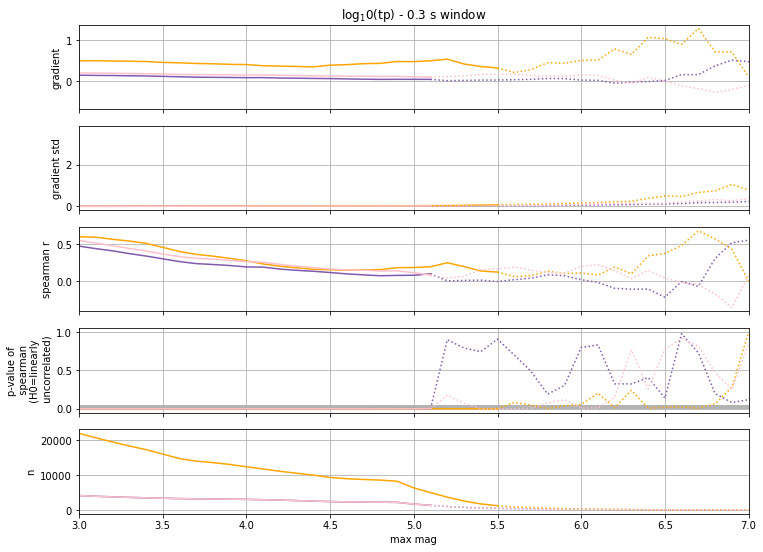

eq_object_05s_bandpass_01_19_snr_20_blank_0_new


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._me

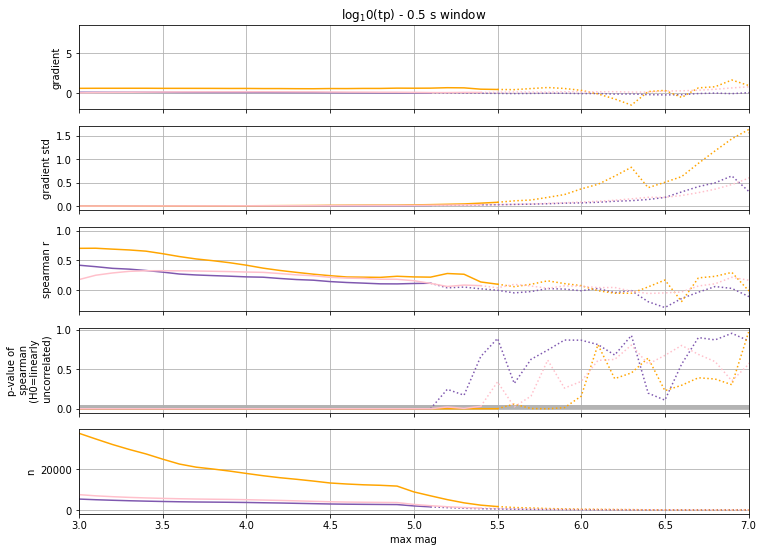

eq_object_1s_bandpass_01_19_snr_20_blank_0_new


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._me

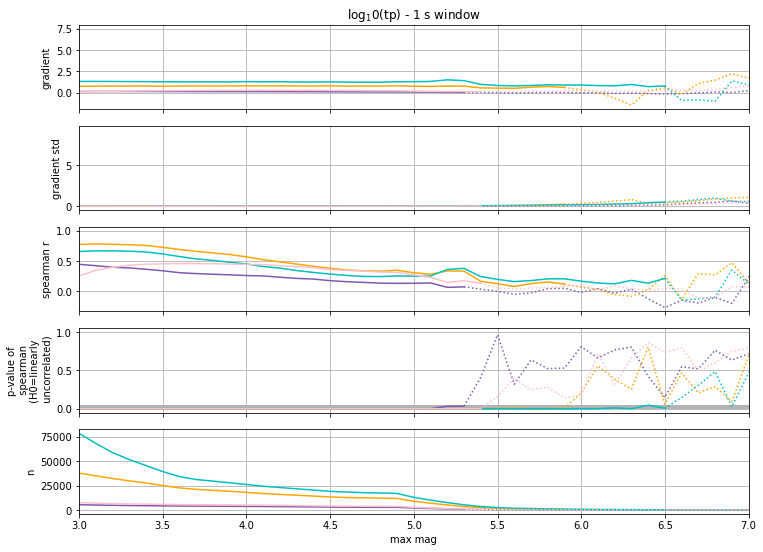

eq_object_4s_bandpass_01_19_snr_20_blank_0_new


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._me

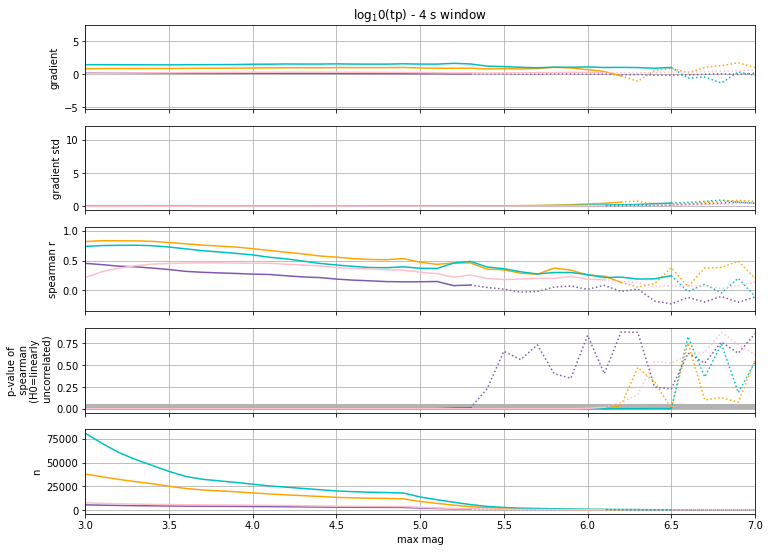

In [465]:
for f in filenames:
    print(f)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    df = pd.read_pickle(f'/home/earthquakes1/homes/Rebecca/phd/data/results_database/{f}')
    for mag_lim in magnitudes:
        x, y = calc_tp_mag_lim(df, mag_lim)
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    tp_params = [gradt, gradt_std, spearman, spearman_p, n, 'tp']
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        x, y = calc_pgd_mag_lim(df, mag_lim)
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    #plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, 'pgd', True)  
    pgd_params = [gradt, gradt_std, spearman, spearman_p, n, 'pgd']
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        x, y = calc_tc_mag_lim(df, mag_lim)
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    #plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, 'pgd', True)  
    tc_params = [gradt, gradt_std, spearman, spearman_p, n, 'tc']
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        x, y = calc_iv2_mag_lim(df, mag_lim)
        #print(len(x[y==0]))
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    iv2_params = [gradt, gradt_std, spearman, spearman_p, n, 'iv2']
    plot_spearman_subplots_all_on_one(f, tp_params, pgd_params, iv2_params, tc_params, save = False)
    #plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, 'iv2', True) 

In [ ]:
for f in filenames:
    print(f)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    df = pd.read_pickle(f'/home/earthquakes1/homes/Rebecca/phd/data/results_database/{f}')
    for mag_lim in magnitudes:
        x, y = calc_tp_mag_lim(df, mag_lim)
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        x, y = calc_pgd_mag_lim(df, mag_lim)
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        x, y = calc_iv2_mag_lim(df, mag_lim)
        #print(len(x[y==0]))
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, 'iv2', True)  

eq_object_03s_bandpass_01_19_snr_20_blank_0_new


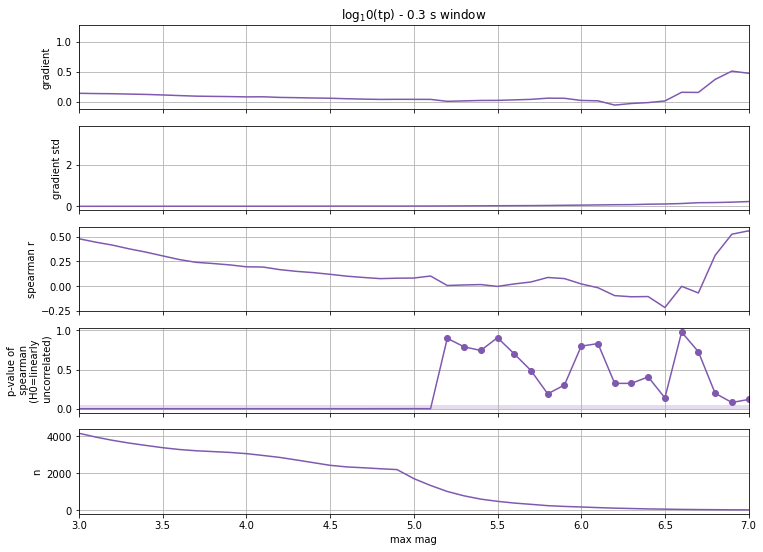

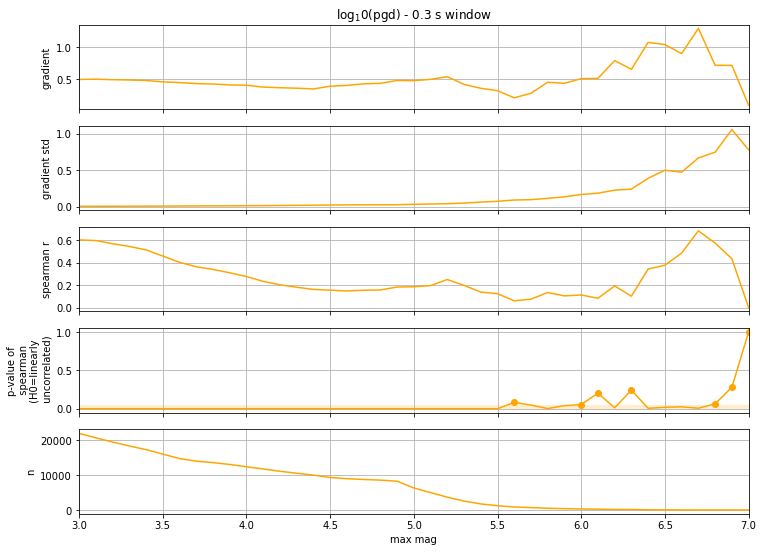

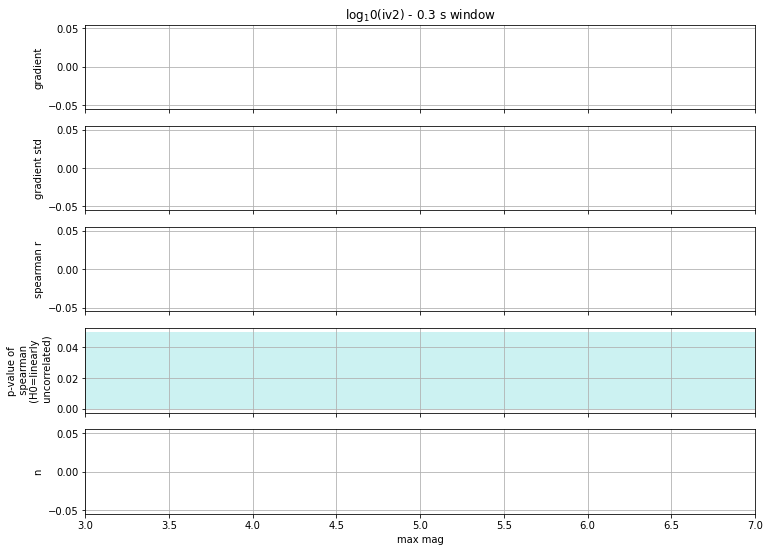

eq_object_05s_bandpass_01_19_snr_20_blank_0_new


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._me

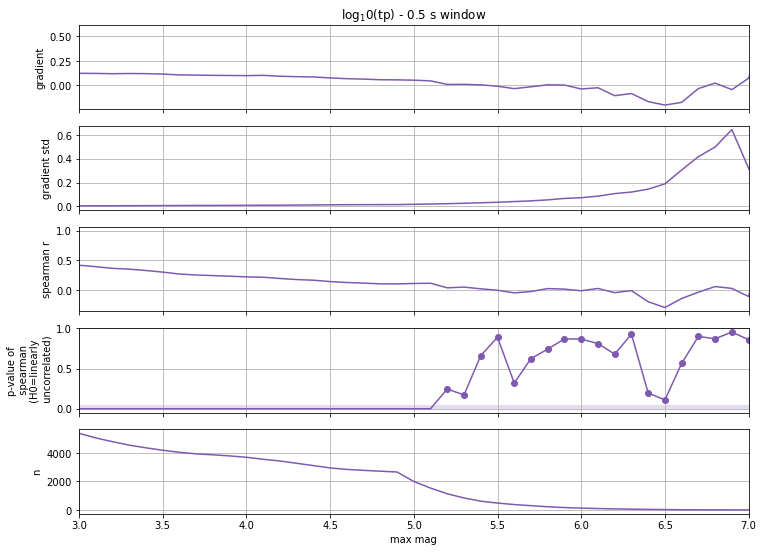

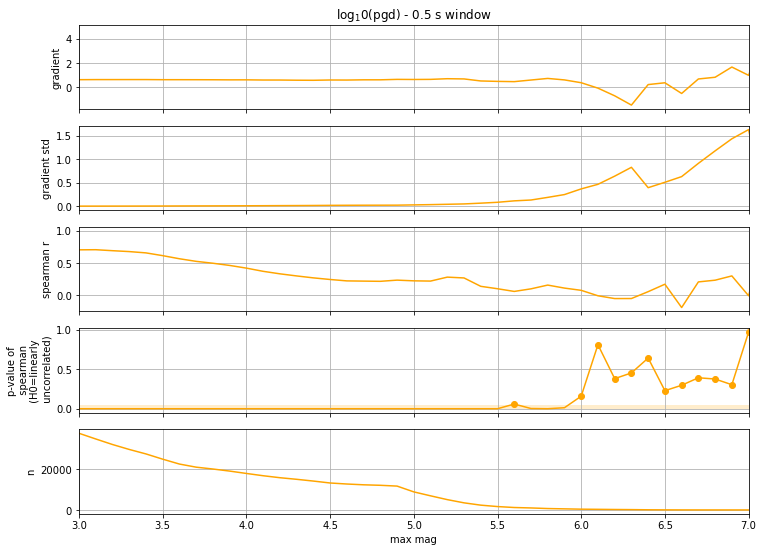

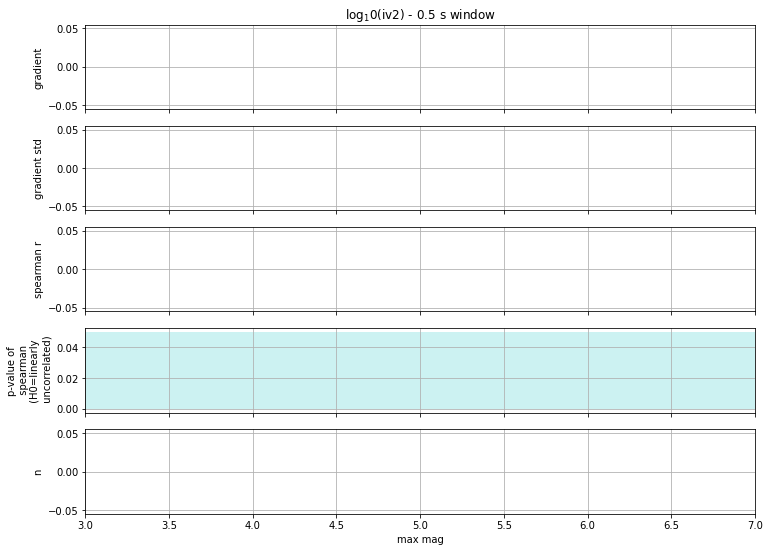

eq_object_1s_bandpass_01_19_snr_20_blank_0_new


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._me

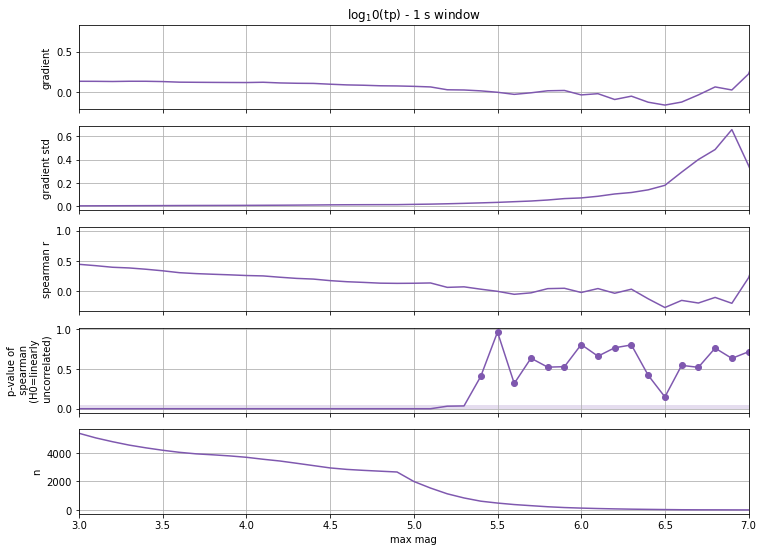

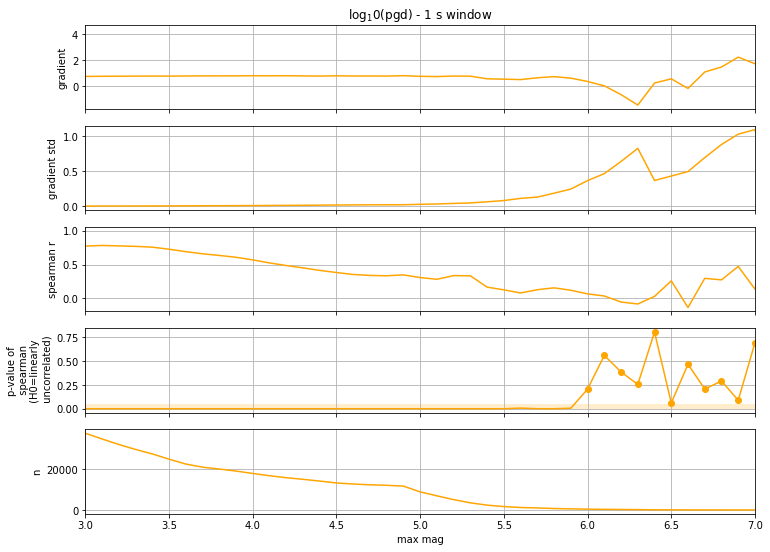

/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/33

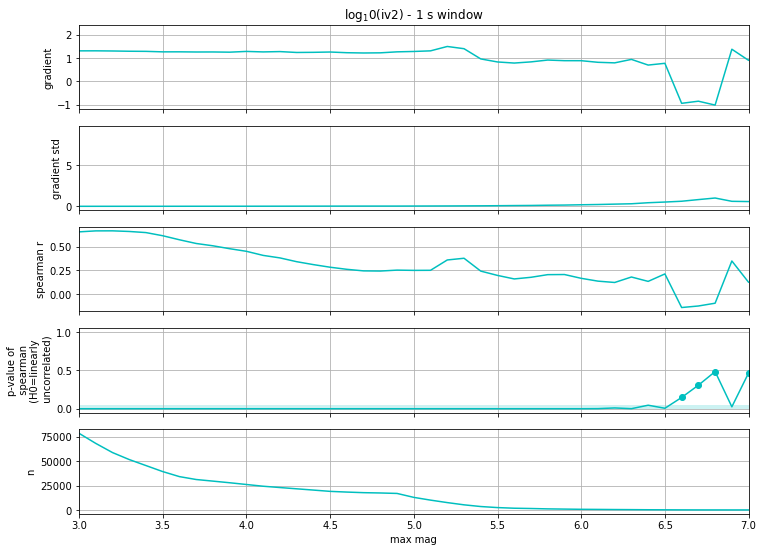

eq_object_4s_bandpass_01_19_snr_20_blank_0_new


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._me

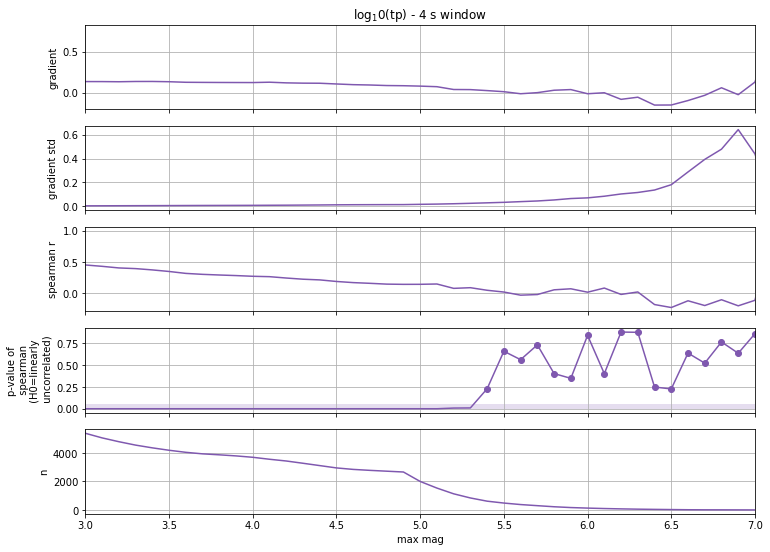

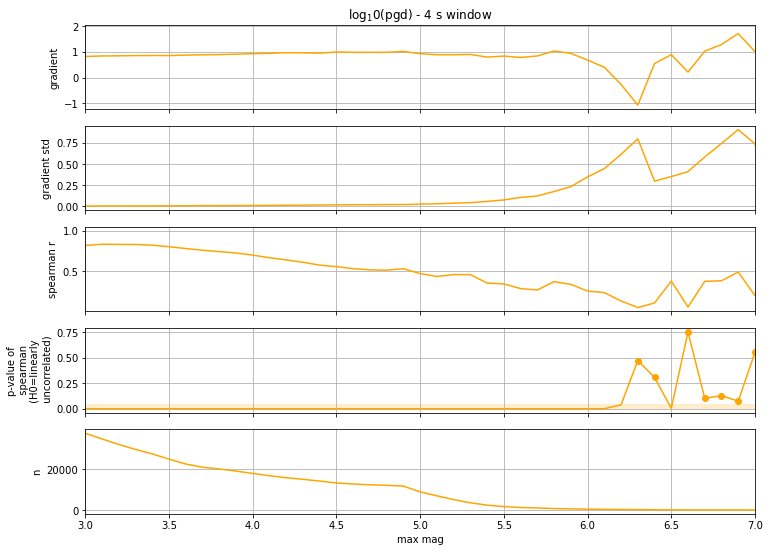

/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/3314710982.py:43: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)
/tmp/ipykernel_828708/33

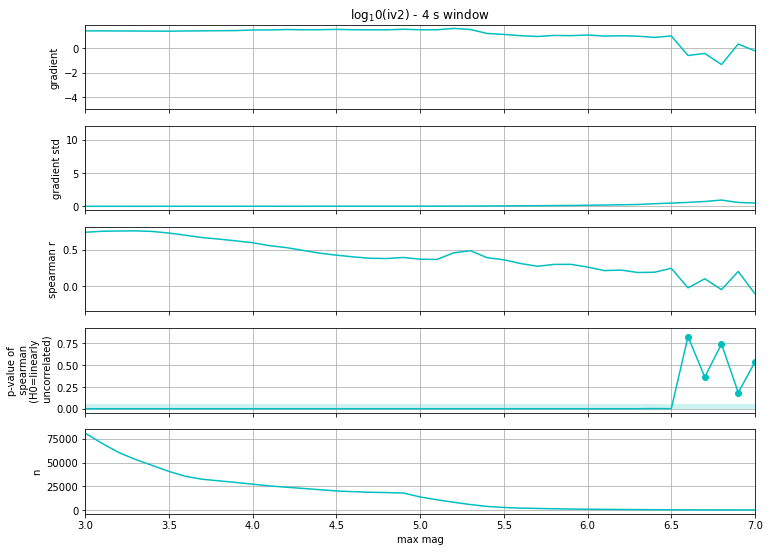

In [375]:
for f in filenames:
    print(f)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    df = pd.read_pickle(f'/home/earthquakes1/homes/Rebecca/phd/data/results_database/{f}')
    for mag_lim in magnitudes:
        x, y = calc_tp_mag_lim(df, mag_lim)
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, 'tp', True)
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        x, y = calc_pgd_mag_lim(df, mag_lim)
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, 'pgd', True)  
    gradt, intercept, gradt_std, intercept_std = [],[],[],[]
    pearson = []
    spearman = []
    spearman_p = []
    n_l = []
    for mag_lim in magnitudes:
        x, y = calc_iv2_mag_lim(df, mag_lim)
        #print(len(x[y==0]))
        gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n = calc_opt(x,y, gradt, intercept, gradt_std, intercept_std, pearson, spearman, spearman_p, n_l)
    plot_spearman_subplots(f, gradt, gradt_std, spearman, spearman_p, n, 'iv2', True)  

In [336]:
list_mag, list_iv2, list_dist = sort_iv2_data(df, 3.)
if len(list_mag)>1 and len(list_dist)>1 and len(list_iv2)>1:
    r_corr = float(1.38)
    dist_corr_mult = (np.array(list_dist)**r_corr)*np.array(list_iv2)
    y = np.log10(dist_corr_mult)
    x = np.array(list_mag) 
    mask = ~np.isnan(x) & ~np.isnan(y)


/tmp/ipykernel_828708/2439252725.py:5: RuntimeWarning: invalid value encountered in log10
  y = np.log10(dist_corr_mult)


In [347]:
list_mag, list_pgd, list_dist = sort_pgd_data(df, 3.)
if len(list_mag)>1 and len(list_dist)>1 and len(list_pgd)>1:
    dist_corr_mult_alt = (np.array(list_dist)**1.38)*np.array(list_pgd)
    df3  = pd.DataFrame({'pgd':np.log10(dist_corr_mult_alt), 'mag':list_mag, 'dist':list_dist})
    y = np.log10(dist_corr_mult_alt)
    x = np.array(list_mag)
    mask = ~np.isnan(x) & ~np.isnan(y)



In [348]:
x

array([5. , 5.4, 5. , ..., 4.7, 4.7, 4.7])

In [351]:
    list_mag, list_pgd, list_dist = sort_pgd_data(df, mag_lim)
    if len(list_mag)>1 and len(list_dist)>1 and len(list_pgd)>1:
        dist_corr_mult_alt = (np.array(list_dist)**1.38)*np.array(list_pgd)
        df3  = pd.DataFrame({'pgd':np.log10(dist_corr_mult_alt), 'mag':list_mag, 'dist':list_dist})
        y = np.log10(dist_corr_mult_alt)
        x = np.array(list_mag)
        mask = ~np.isnan(x) & ~np.isnan(y)

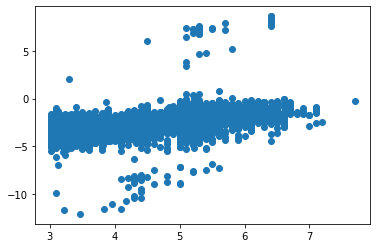

In [352]:
plt.scatter(x,y)

In [298]:
max(y)

623411340.0412273